In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,Activation,add,multiply
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import regularizers
from keras.layers.merge import concatenate
from keras.layers.core import Lambda

Using TensorFlow backend.
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/poudelas/anaco

In [2]:
import tensorflow as tf

In [3]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [4]:
im_width = 224
im_height = 224
border = 5
path_train = '/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/train1/'
path_test = '/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/test1/'

In [88]:
# seed = 1 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
# image_datagen = ImageDataGenerator(
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                  ) # custom fuction for each image you can use resnet one too.
# mask_datagen = ImageDataGenerator(width_shift_range=0.1,
#                  height_shift_range=0.1,
                 
#                  )  # to make mask as feedable formate (256,256,1)

# image_generator =image_datagen.flow_from_directory("/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/train/image",
#                                                     class_mode=None, seed=seed,
#                                                     target_size = (224, 224))

# mask_generator = mask_datagen.flow_from_directory("/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/train/mask/",
#                                                    class_mode=None, 
#                                                    seed=seed,
#                                                    target_size = (224, 224))

# train_generator = zip(image_generator, mask_generator)

Found 795 images belonging to 1 classes.
Found 795 images belonging to 1 classes.


In [89]:

valid_generator_image =image_datagen.flow_from_directory("/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/validation/image",
                                                    class_mode=None, seed=seed)

valid_mask_generator = mask_datagen.flow_from_directory("/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/validation/mask/",
                                                   class_mode=None, seed=seed)

valid_generator = zip(valid_generator_image, valid_mask_generator)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


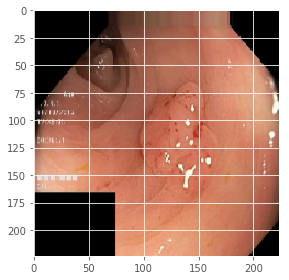

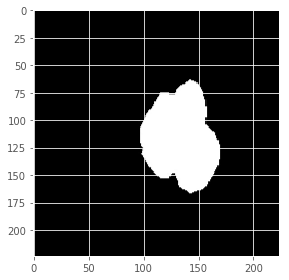

In [90]:
# from matplotlib import pyplot as plt
# %matplotlib inline

# imshow(image_generator.next()[10].astype(np.uint8))
# plt.show()
# imshow(np.squeeze(mask_generator.next()[10].astype(np.uint8)))
# plt.show()

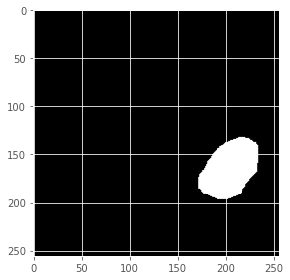

In [5]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "image"))[2]
    X = np.zeros((len(ids), 224, 224, 3), dtype=np.uint8)
    y = np.zeros((len(ids), 224, 224, 1), dtype=np.bool)
  
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        #img = load_img(path + '/image/' + id_, grayscale=False)
        img = imread(path + '/image/' + id_)[:,:,:3]
        img = resize(img, (224, 224), mode='constant', preserve_range=True)
        #X[n] = img
        
        mask = img_to_array(load_img(path + 'mask/'+id_, grayscale=True))
        mask = resize(mask, (224, 224, 1), mode = 'constant', preserve_range = True)
        
        X[n] = img
        y[n] = mask
        
#         mask_ = imread(path + '/mask/' + id_)
#         mask_ = np.expand_dims(resize(mask_, (224, 224), mode='constant', 
#                                           preserve_range=True), axis=-1)
#         print(mask_.shape)
#         print(y.shape)
#         mask = np.maximum(y, mask_)
            
#         y[n]=mask_
        
    return X,y
   

In [6]:
X_train, Y_train = get_data(path_train, train=True)

Getting and resizing images ... 


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [7]:
BATCH_SIZE = 10
seed = 1
from keras.preprocessing import image
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

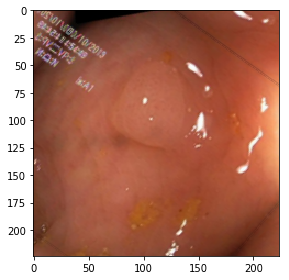

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


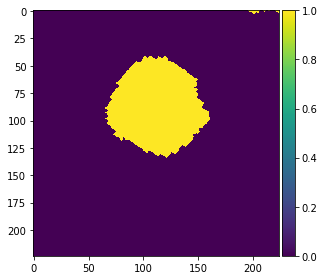

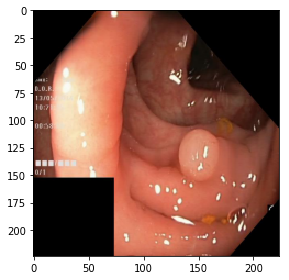

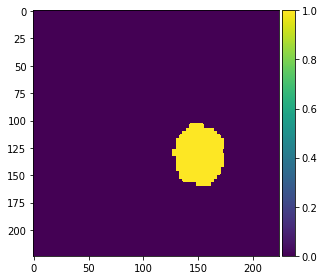

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [12]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

In [9]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

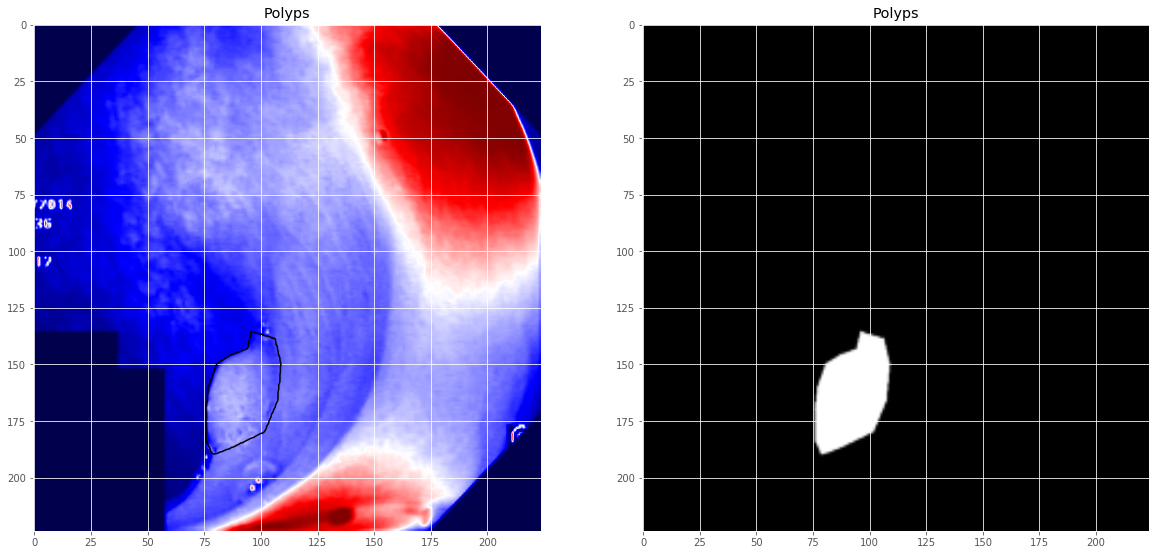

In [13]:

plt.style.use("ggplot")
%matplotlib inline

ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Polyps')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Polyps');

In [10]:
smooth = 1
def dice_coef(y_true, y_pred):# y_true为真实准确值，y_pred为预测值
    y_true_f = K.flatten(y_true)# 捋直
    y_pred_f = K.flatten(y_pred)# 捋直
    # K.sum不加axi（指定方向求和，返回对应方向向量）,则为全元素求和，返回一个数字
    intersection = K.sum(y_true_f * y_pred_f)# 求预测准确的结果（真实准确值和预测值的交集）
    # 原始公式：（2*预测准确值）/（真实准确值+预测值），越大效果越好
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [11]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [12]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [13]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [14]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x



In [196]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [15]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(lr = 0.00001), loss="binary_crossentropy", metrics=["accuracy"])

In [37]:
def attention_and_concatenate2(first_layer,second_layer,number_of_channel):
    first = Conv2D(number_of_channel,[1,1],strides=[1,1])(first_layer)
    second = Conv2D(number_of_channel,[1,1],strides=[1,1])(second_layer)
    f = Activation('relu')(add([first,second]))

    psi_f = Conv2D(1,[1,1], strides=[1,1])(f)
    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([first,rate])
    return att_x
def attention_and_concatenate3(first_layer,second_layer,third_layer,number_of_channel):
    first = Conv2D(number_of_channel,[1,1],strides=[1,1])(first_layer)
    second = Conv2D(number_of_channel,[1,1],strides=[1,1])(second_layer)
    third = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(third_layer)
    f = Activation('relu')(add([first,second,third]))

    psi_f = Conv2D(1,[1,1], strides=[1,1])(f)
    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([first,rate])
    return att_x
def attention_and_concatenate4(first_layer,second_layer,third_layer,fourth_layer,number_of_channel):
    first = Conv2D(number_of_channel,[1,1],strides=[1,1])(first_layer)
    second = Conv2D(number_of_channel,[1,1],strides=[1,1])(second_layer)
    third = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(third_layer)
    fourth = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(fourth_layer)
    f = Activation('relu')(add([first,second,third,fourth]))

    psi_f = Conv2D(1,[1,1], strides=[1,1])(f)
    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([first,rate])
    return att_x
def attention_and_concatenate5(first_layer,second_layer,third_layer,fourth_layer,fifth_layer,number_of_channel):
    first = Conv2D(number_of_channel,[1,1],strides=[1,1])(first_layer)
    second = Conv2D(number_of_channel,[1,1],strides=[1,1])(second_layer)
    third = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(third_layer)
    fourth = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(fourth_layer)
    fifth = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(fifth_layer)
    f = Activation('relu')(add([first,second,third,fourth,fifth]))

    psi_f = Conv2D(1,[1,1], strides=[1,1])(f)
    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([first,rate])
    return att_x

In [38]:
def get_unetpp(num_class=1, deep_supervision=False):
    nb_filter = [32, 64, 128, 256, 512]
    img_rows = 224
    img_cols = 224
    color_type = 3
    bn_axis = 3

    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(img_input)
    conv1_1 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(pool1)
    conv2_1 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_1)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    att1_2 = attention_and_concatenate2(up1_2,conv1_1,nb_filter[0])
    conv1_2 = concatenate([att1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_2)
    conv1_2 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_2)

    conv3_1 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(pool2)
    conv3_1 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3_1)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    att2_2 = attention_and_concatenate2(up2_2,conv2_1,nb_filter[1])
    conv2_2 = concatenate([att2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_2)
    conv2_2 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_2)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    att1_3 = attention_and_concatenate3(conv1_1,conv1_2,up1_3,nb_filter[0])
    conv1_3 = concatenate([att1_3, conv1_1,conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_3)
    conv1_3 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_3)

    conv4_1 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(pool3)
    conv4_1 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(conv4_1)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    att3_2 = attention_and_concatenate2(conv3_1,up3_2,nb_filter[2])
    conv3_2 = concatenate([att3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3_2)
    conv3_2 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3_2)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    att2_3 = attention_and_concatenate3(conv2_1,conv2_2,up2_3,nb_filter[1])
    conv2_3 = concatenate([att2_3,conv2_1,conv2_2,up2_3], name='merge23', axis=bn_axis)
    conv2_3 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_3)
    conv2_3 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_3)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    att1_4 = attention_and_concatenate4(conv1_1,conv1_2,conv1_3,up1_4,nb_filter[0])
    conv1_4 = concatenate([att1_4,conv1_1,conv1_2,conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_4)
    conv1_4 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_4)

    # conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])
    conv5_1 = Conv2D(nb_filter[4], (3, 3), activation='relu', padding='same')(pool4)
    conv5_1 = Conv2D(nb_filter[4], (3, 3), activation='relu', padding='same')(conv5_1)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    att4_2 = attention_and_concatenate2(conv4_1,up4_2,nb_filter[3])
    conv4_2 = concatenate([att4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(conv4_2)
    conv4_2 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(conv4_2)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    att3_3 = attention_and_concatenate3(conv3_1,conv3_2,up3_3,nb_filter[2])
    conv3_3 = concatenate([att3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3_3)
    conv3_3 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3_3)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    att2_4 = attention_and_concatenate4(conv2_1,conv2_2,conv2_3,up2_4,nb_filter[1])
    conv2_4 = concatenate([att2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_4)
    conv2_4 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_4)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    att1_5 = attention_and_concatenate5(conv1_1,conv1_2,conv1_3,conv1_4,up1_5,nb_filter[0])
    conv1_5 = concatenate([att1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_5)
    conv1_5 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_5)

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer='he_normal',
                              padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer='he_normal',
                              padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer='he_normal',
                              padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer='he_normal',
                              padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_5)

    model = Model(input=img_input, output=[nestnet_output_4])

    # optimizer：优化器，如Adam
    # loss:计算损失，dice_coef_loss损失函数
    # metrics: 列表，包含评估模型在训练和测试时的性能的指标，dice_coef
    model.compile(optimizer=Adam(lr = 0.00001), loss="binary_crossentropy", metrics=["accuracy"])  # dice_coef_loss损失函数

    return model


In [39]:
model = get_unetpp()
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 32) 896         main_input[0][0]                 
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 224, 224, 32) 9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 112, 112, 32) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ma..., outputs=[<tf.Tenso...)`


In [17]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=6, min_lr=0.000001, verbose=1),
    ModelCheckpoint('check5.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [18]:
# results = model.fit(X_train, y_train, batch_size=8, epochs=10, callbacks=callbacks,
#                     validation_data=(X_valid, y_valid))
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=50, steps_per_epoch=100,
                              epochs=5, callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - 11s 113ms/step - loss: 0.8939 - acc: 0.4334 - val_loss: 0.8368 - val_acc: 0.4489

Epoch 00001: val_loss improved from inf to 0.83679, saving model to check5.h5
Epoch 2/5
100/100 [==============================] - 9s 88ms/step - loss: 0.8261 - acc: 0.4548 - val_loss: 0.7751 - val_acc: 0.4963

Epoch 00002: val_loss improved from 0.83679 to 0.77512, saving model to check5.h5
Epoch 3/5
100/100 [==============================] - 9s 90ms/step - loss: 0.7711 - acc: 0.5096 - val_loss: 0.7234 - val_acc: 0.6029

Epoch 00003: val_loss improved from 0.77512 to 0.72345, saving model to check5.h5
Epoch 4/5
100/100 [==============================] - 9s 91ms/step - loss: 0.7251 - acc: 0.5732 - val_loss: 0.6741 - val_acc: 0.6735

Epoch 00004: val_loss improved from 0.72345 to 0.67414, saving model to check5.h5
Epoch 5/5
100/100 [==============================] - 9s 91ms/step - loss: 0.6877 - acc: 0.6260 - val_loss: 0.6274 - val_acc: 0.7156

Epoch 000

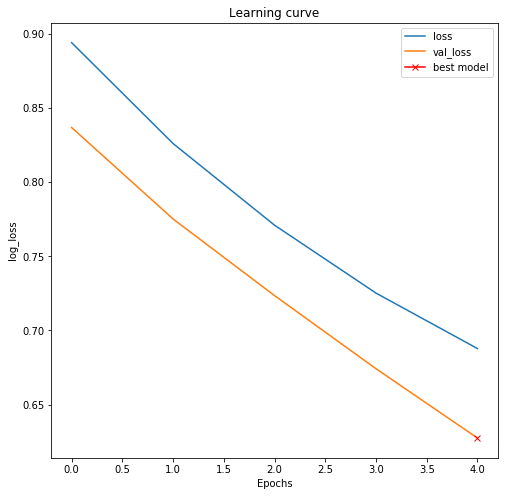

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [22]:
import sys
from tqdm import tqdm
TEST_PATH = '/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/test1/'
test_ids = next(os.walk(TEST_PATH+'img'))[2]
X_test = np.zeros((len(test_ids), 224, 224, 3), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH + 'img/' + id_)[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (224, 224), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 105/105 [00:02<00:00, 39.70it/s]

Done!


In [23]:
# Load best model
model.load_weights('check5.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

105/105 [==============================] - 0s 2ms/step


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(preds_val, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
target_names = ['polyps']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


Confusion Matrix


AttributeError: 'zip' object has no attribute 'classes'

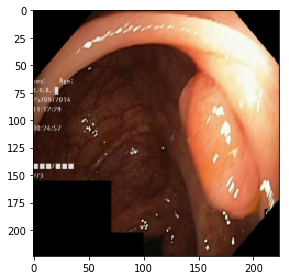

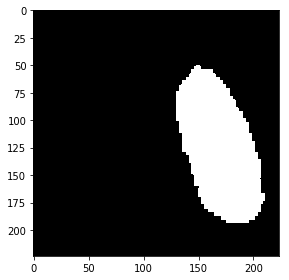

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


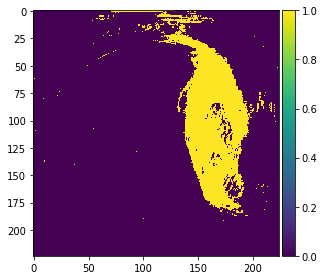

In [66]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

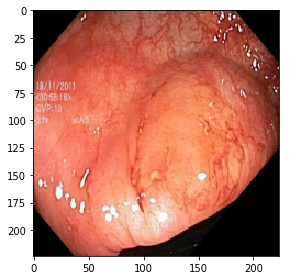

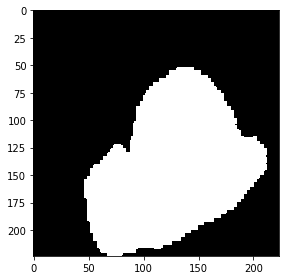

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


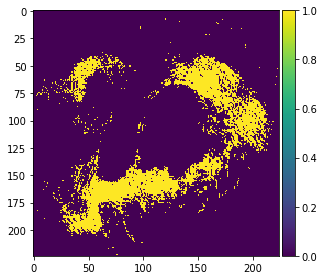

In [63]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [61]:
model.evaluate(X_valid, y_valid, verbose=1)

120/120 [==============================] - 2s 18ms/step


[0.34631714423497517, 0.8216913024584452]

In [64]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

795/795 [==============================] - 9s 11ms/step


NameError: name 'X_valid' is not defined

In [63]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('polyp')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('polyp Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('polyp Predicted binary');

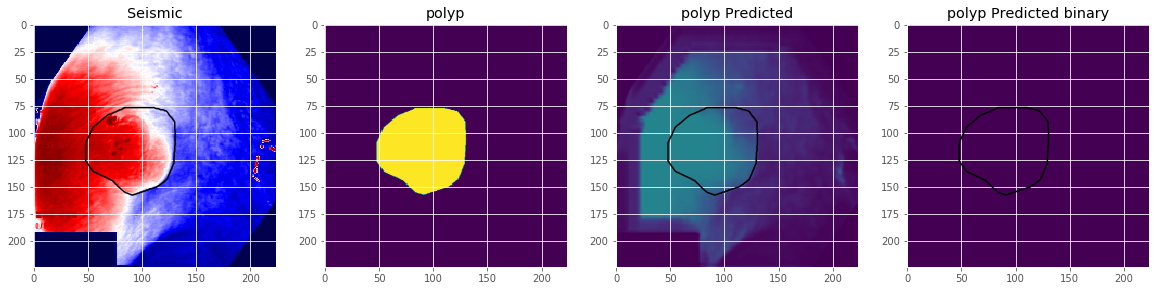

In [64]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

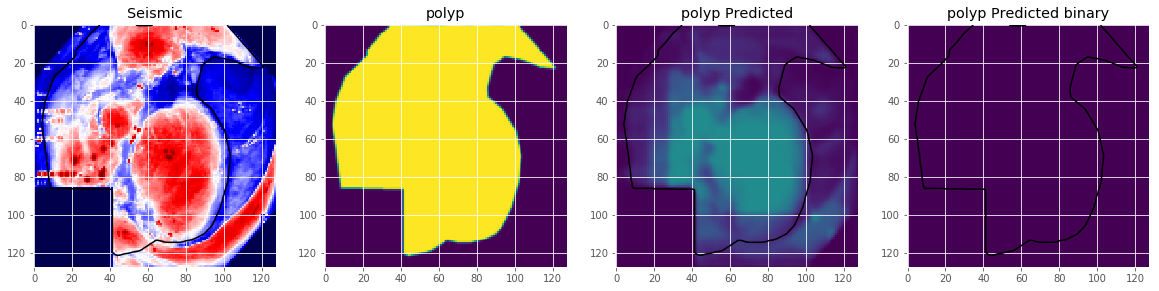

In [35]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)